In [1]:
from deap import base, creator, tools, algorithms
import deap.benchmarks.tools as bt
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi, sin
import operator
import pandas as pd

creator.create("obj", base.Fitness, weights=(-1.0,-1.0, -1.0))

creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'total_pf': {'min': 0.05, 'max': 0.07},
  'sine_a_x': {'min': 0.0, 'max': 2.0},
  'sine_b_x': {'min': 0.0, 'max': 1.57},
  'sine_c_x': {'min': 0.0, 'max': 6.28},
  'sine_a_y': {'min': 0.0, 'max': 2.0},
  'sine_b_y': {'min': 0.0, 'max': 1.57},
  'sine_c_y': {'min': 0.0, 'max': 6.28},
  'r1': {'min': 0.1, 'max': 0.35},
  'r2': {'min': 0.1, 'max': 0.35},
  'r3': {'min': 0.1, 'max': 0.35},
  'r4': {'min': 0.1, 'max': 0.35},
  'r5': {'min': 0.1, 'max': 0.35}},
 'evaluators': {'openmc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc.py'],
   'execute': [['aprun -n 2 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2'],
    ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ../../../../../moltres/python/moltres_xs.py',
     'fhr_assem_gc.inp']],
   'inputs': ['total_pf',
    'sine_a_x',
    'sine_b_x',
    'sine_c_x',
    'sine_a_y',
    'sine_b_y',
    'sine_c_y',
    'r1',
    'r2',
    'r3',
    'r4',
    'r5'],
   '

In [4]:
results = cp["all"]
ref = np.array([0.07, 1700 ,1.8])
for pop in results["populations"]:
    non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    hypervol = bt.hypervolume(non_dom, ref)
    print(hypervol)

5.496135901572641
5.67395975123347
5.687642067401377
5.810468836884034
6.0023753521258385
6.009396882971004


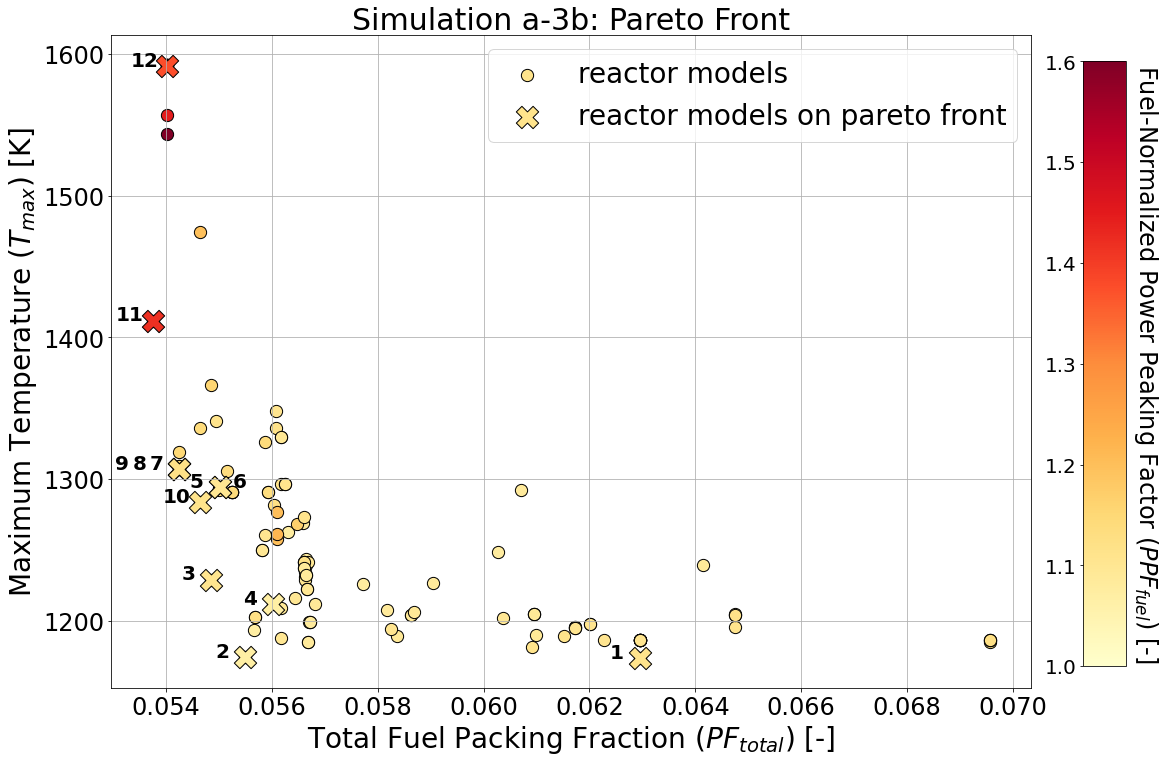

In [5]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "indianred", "lime", "magenta", "royalblue"]*2
results = cp["all"]
pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig, ax = plt.subplots(figsize=(12, 12))
count1, count2 = 0, 0
for i, ind in enumerate(pop):
    if count1 == 0:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.0, 
                   vmax=1.6, cmap="YlOrRd", marker='o',edgecolors='black', alpha=1, s=150,
                   label="reactor models")
        count1 += 1
    else:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.0, 
                   vmax=1.6, cmap="YlOrRd", marker='o',edgecolors='black', alpha=1, s=150)
prev_0, prev_1 = 0, 0
num = 1
for i, ind in enumerate(final_non_dom):
    if count2 == 0:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.0, 
                   vmax=1.6, cmap="YlOrRd", marker="X", s=500, edgecolors='black', alpha=1,
                   label="reactor models on pareto front")
        count2 += 1
    else:
        im = ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.0, 
                    vmax=1.6, cmap="YlOrRd", marker="X", s=500, edgecolors='black', alpha=1)
    if num < 100:
        offset_0, offset_1 = abs(ind.output[0]-prev_0), abs(ind.output[1]-prev_1)
        offset_y = 0
        if offset_0 < 0.002 and offset_1 < 0.01:
            if num < 10:
                offset_x -= 17
            else:
                offset_x -= 30
        else:
            offset_x = -23
        if num == 6:
            offset_x = 20
        ax.annotate(str(num), (ind.output[0], ind.output[1]), textcoords="offset points", 
                    xytext=(offset_x,offset_y), ha='center', weight='bold', fontsize=20) 
        prev_0, prev_1 = ind.output[0], ind.output[1]
    num += 1
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=28, bbox_to_anchor = [1.0, 1.0])
ax.tick_params(axis='both', which='major', labelsize=24)
fig.subplots_adjust(right=1.19)
cbar_ax = fig.add_axes([1.25, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cbar_ax.yaxis.set_ticks_position('left')
ax.set_ylabel(r'Maximum Temperature ($T_{max}$) [K]',fontsize=28)
ax.set_xlabel(r'Total Fuel Packing Fraction ($PF_{total}$) [-]',fontsize=28)
cb.set_label(r'Fuel-Normalized Power Peaking Factor ($PPF_{fuel}$) [-]', fontsize=24, rotation=270, labelpad=34)
ax.set_title('Simulation a-3b: Pareto Front',fontsize=30)
plt.savefig("assem-obj-3-all-2d.png",bbox_inches='tight', dpi=300)


In [6]:
total_pf, total_temp, total_ppf = 0, 0, 0
for ind in final_non_dom:
    total_pf += ind.output[0]
    total_temp += ind.output[1]
    total_ppf += ind.output[2]
print(total_pf/len(final_non_dom), total_temp/len(final_non_dom),total_ppf/len(final_non_dom))

0.05537846027917028 1298.742448325483 1.152549430348808


Text(0.5, 0.9384, "Final Generation's Pareto Front")

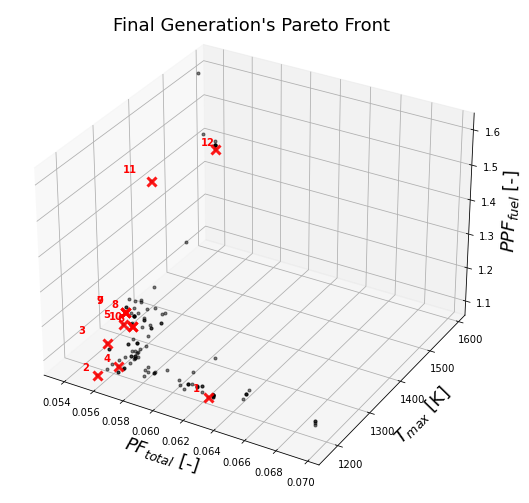

In [7]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "indianred", "lime", "magenta", "royalblue"]*2
results = cp["all"]
pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')
for ind in pop:
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], ind.fitness.values[2], 'k.', ms=6, alpha=0.5)
count = 1
prev_x_pos = 0
for i, ind in enumerate(final_non_dom):
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], ind.fitness.values[2], 'x', alpha=0.9, ms=9, mew=3, color="red")
    x_pos = ind.fitness.values[0]-0.001
    if abs(prev_x_pos - x_pos) < 0.001:
        x_pos -= 0.001
    ax.text(x_pos, ind.fitness.values[1], ind.fitness.values[2], count, color="red", 
            weight='bold')
    prev_x_pos = x_pos
    count += 1
#ax.legend()
ax.grid()
ax.set_xlabel('$PF_{total}$ [-]',fontsize=18)
ax.set_ylabel('$T_{max}$ [K]',fontsize=18)
ax.set_zlabel('$PPF_{fuel}$ [-]', fontsize=18)
ax.set_title("Final Generation's Pareto Front",fontsize=18, y=1.02)
#ax.set_xlim(0.02, 0.035)
#ax.set_xticks([0.02, 0.025, 0.03, 0.035])
#ax.set_ylim(1125, 1200)
#ax.set_yticks([1130, 1150, 1170, 1190])
#ax.set_zlim(1.0, 1.15)
#ax.set_zticks([1.0, 1.05, 1.1, 1.15])
#plt.savefig("slab-obj-3-3d.png",bbox_inches='tight')

In [8]:
len(final_non_dom)

12

Text(0.5, 1.0, 'Simulation a-3b: Pareto Front')

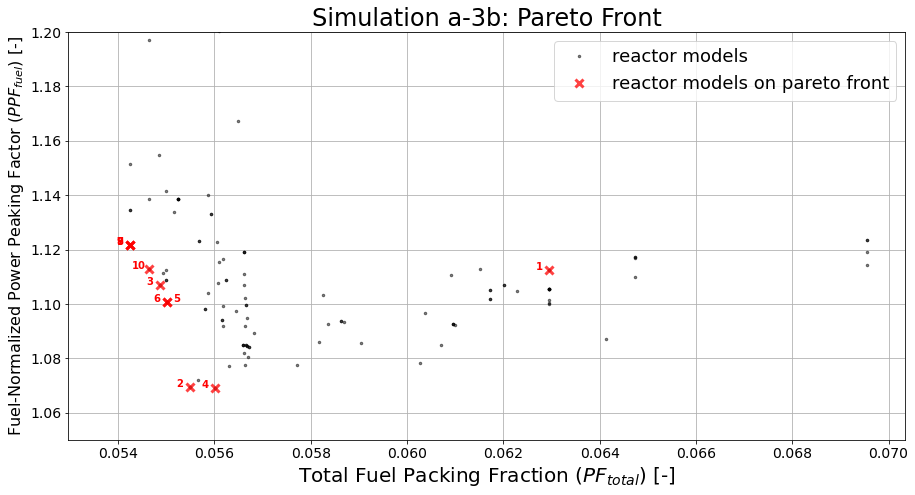

In [9]:
results = cp["all"]
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]

fig, ax = plt.subplots(figsize=(15,7.5))
count1, count2 = 0, 0
for ind in final_pop:
    if count1 == 0:
        ax.plot(ind.output[0], ind.output[2], 'k.', ms=5, alpha=0.5, label="reactor models")
        count1 += 1
    else:
        ax.plot(ind.output[0], ind.output[2], 'k.', ms=5, alpha=0.5)
num = 1
prev_0, prev_1 = 0, 0
for ind in final_non_dom:
    if count2 == 0:
        ax.plot(ind.output[0], ind.output[2], 'rx', alpha=0.74, ms=8, mew=3, label="reactor models on pareto front")
        count2 += 1
    else:
        ax.plot(ind.output[0], ind.output[2], 'rx', alpha=0.74, ms=8, mew=3)
    if num < 100:
        offset_0, offset_1 = abs(ind.output[0]-prev_0), abs(ind.output[2]-prev_1)
        offset_y = 0
        if offset_0 < 0.002 and offset_1 < 0.01:
            if num < 10:
                offset_x -= 20
            else:
                offset_x -= 15
        else:
            offset_x = -10
        if num in [5]:
            offset_x = 10
        #if num in [5,7,10]:
        #    offset_x = 20
        #if num in [11]:
        #    offset_x = -25
        #print(num, offset_x)
        ax.annotate(str(num), (ind.output[0], ind.output[2]), textcoords="offset points", 
                    xytext=(offset_x,offset_y), ha='center', color='r', weight='bold') 
        prev_0, prev_1 = ind.output[0], ind.output[1]
    num += 1
#ax.set_xlim([0.057, 0.061])
ax.set_ylim(1.05, 1.2)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
ax.set_ylabel(r'Fuel-Normalized Power Peaking Factor ($PPF_{fuel}$) [-]',fontsize=16)
ax.set_xlabel(r'Total Fuel Packing Fraction ($PF_{total}$) [-]',fontsize=20)
ax.set_title('Simulation a-3b: Pareto Front',fontsize=24)
#plt.savefig("assem-obj-2-pfppf-pareto",bbox_inches='tight')

In [10]:
midpoints_discr_x = np.array([ 6.18871652,  8.22745601, 10.2661955,  12.304935,  14.34367449, 16.38241398,
 18.42115347, 20.45989297, 22.49863246, 24.53737195])
midpoints_discr_y = np.array([19.775, 16.525, 13.275, 10.025,  6.775,  3.525])
def calc_pf_distr(ind, pf_present):
    if pf_present:
        total_pf, sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5], ind[6]
    else:
        sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5]
    
    sine_val_discr_x = sine_a_x * sin(sine_b_x * midpoints_discr_x + sine_c_x) + 2
    sine_val_discr_y = sine_a_y * sin(sine_b_y * midpoints_discr_y + sine_c_y) + 2
    sine_val_distr_xy = sine_val_discr_y.reshape(6,1) * sine_val_discr_x.reshape(1,10) 
    vol_triso = 0.0003181623994807103
    vol_total = 419.3793150536547
    vol_slice = 6.989655250894246
    no_trisos = total_pf * vol_total / vol_triso
    triso_distr = sine_val_distr_xy / sum(sum(sine_val_distr_xy)) * no_trisos
    pf_distr = triso_distr * vol_triso / vol_slice
    return pf_distr

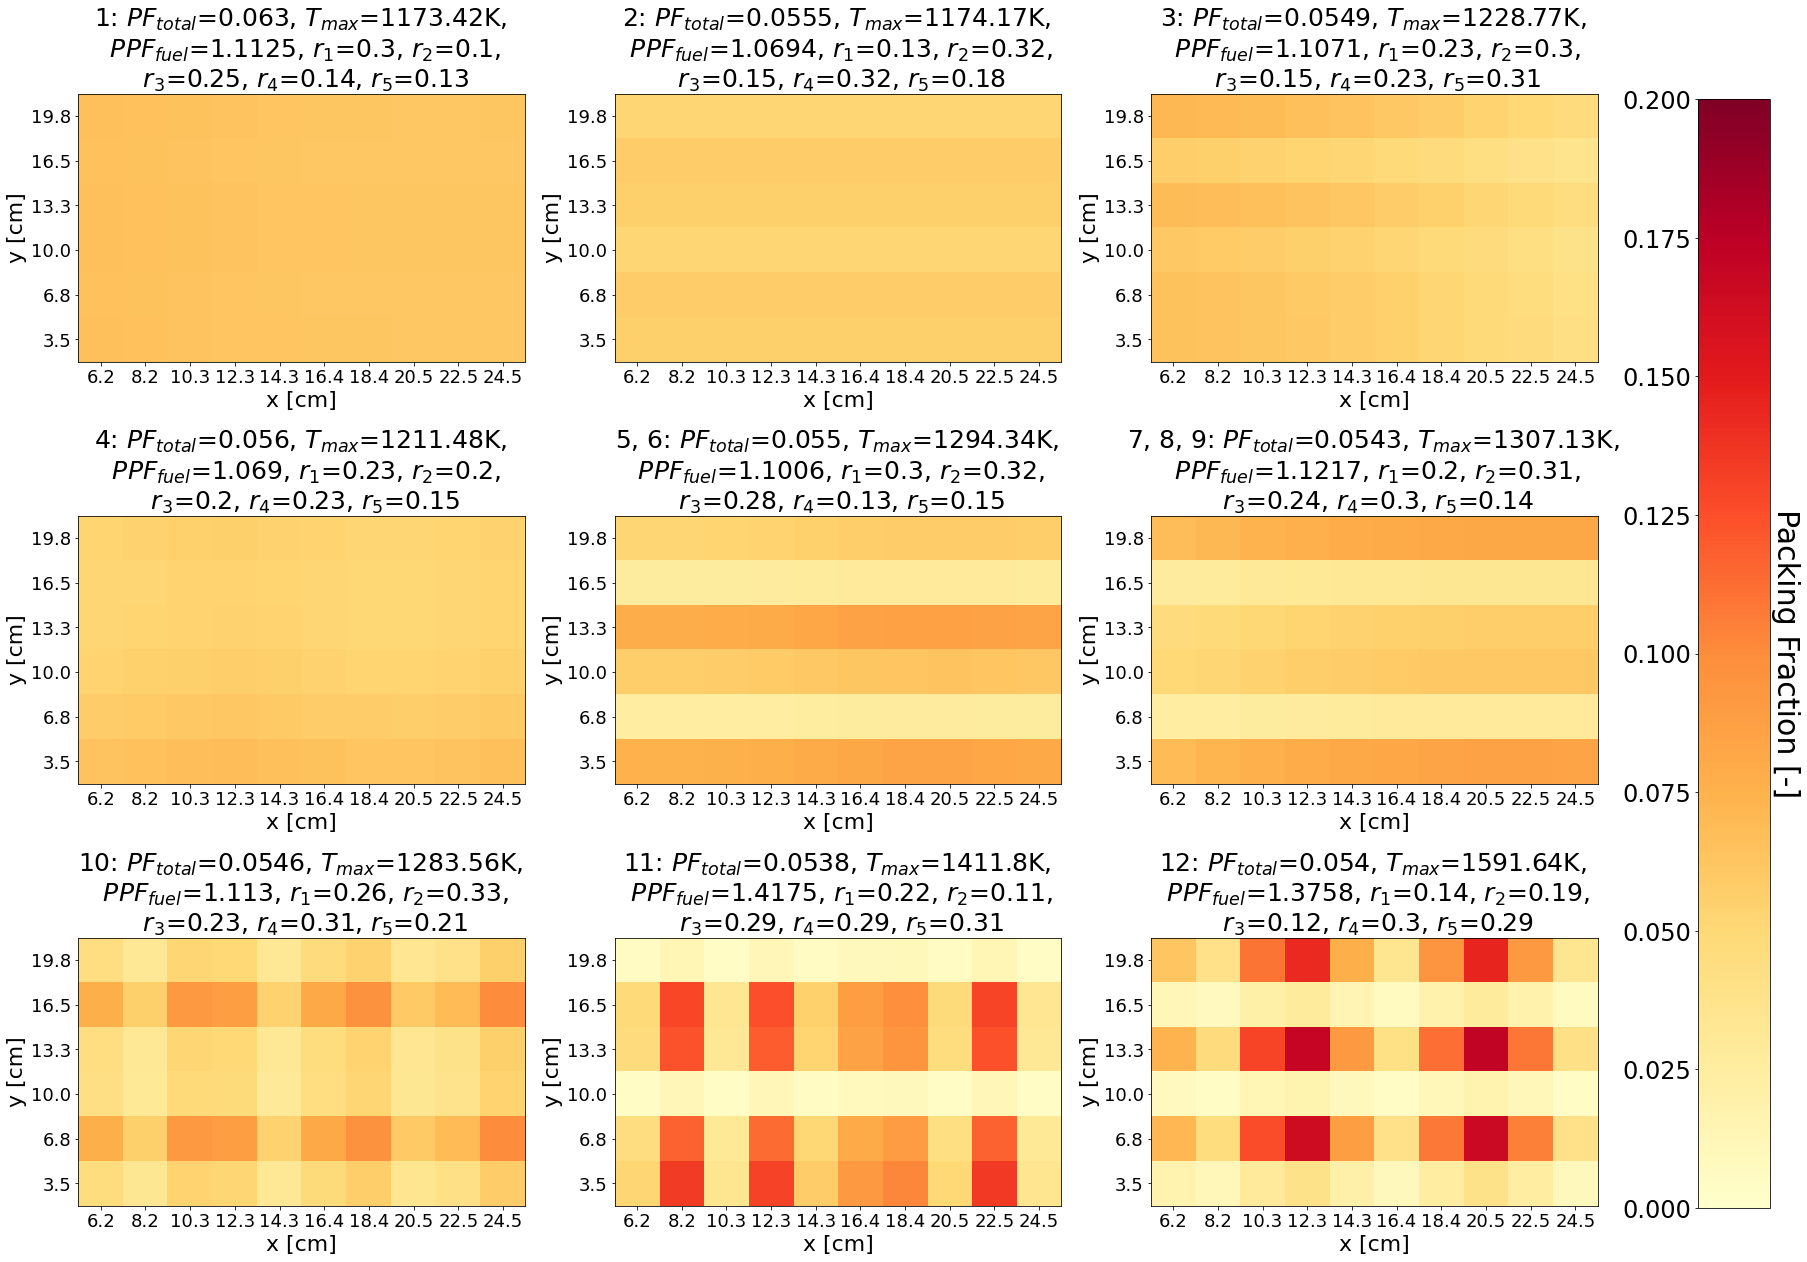

In [11]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
fig, axes = plt.subplots(figsize=(20,22), nrows=3, ncols=3)
count = 0
num = 1
prev_pf, prev_temp, prev_ppf = 0, 0, 0
for i, ind in enumerate(final_non_dom):
    if ind.output[0] != prev_pf and ind.output[1] != prev_temp and ind.output[2] != prev_ppf:
        ax = axes.flat[count]
        count += 1
        pf_distr = calc_pf_distr(ind, True)
        #print(pf_distr)
        im = ax.imshow(pf_distr, vmin=0.00, vmax=0.2,cmap="YlOrRd")
        if i+1 == 5:
            nums = "5, 6"
        elif i+1 == 7:
            nums = "7, 8, 9"
        else:
            nums = str(i+1)
        ax.set_title(nums+": $PF_{total}$="+str(round(ind.output[0],4)) + ", $T_{max}$="+str(round(ind.output[1],2))+"K, \n $PPF_{fuel}$="+str(round(ind.output[2],4)) +\
                     ", $r_1$=" + str(round(ind[7],2)) + ", $r_2$=" + str(round(ind[8],2)) + ",\n $r_3$=" + str(round(ind[9],2)) +\
                     ", $r_4$=" + str(round(ind[10],2)) + ", $r_5$=" + str(round(ind[11],2)), fontsize=25)
        ax.set_xlabel("x [cm]", fontsize=22)
        ax.set_ylabel("y [cm]", fontsize=22)
        ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=18)
        ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=18)
        num += 1
        prev_pf, prev_temp, prev_ppf = ind.output[0], ind.output[1], ind.output[2]
fig.subplots_adjust(right=1.18)
cbar_ax = fig.add_axes([1.25, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.ax.tick_params(labelsize=24)
cb.set_label("Packing Fraction [-]", fontsize=30, rotation=270, labelpad=30)
plt.savefig("assem-obj-3-all-distr",bbox_inches='tight', dpi=300)

PF, TEMP, PPF 11 1 4
gen, num 0 110
10 STD 0.04453350408317872
0.007819686153318895
0.07858942063503087
0.07524642373333988
0.007462420637508115
0.07134535564128165
0.08207358223716185
gen, num 4 4
0 STD 0.0014859720408512318
0.0629690091583128
0.06246267115385673
0.0634267404764119
0.06347566602881599
0.06248838348251272
0.06290788413122018
gen, num 5 16
3 STD 0.004792171713598508
0.05365859086457055
0.05186536005645823
0.052173036479791865
0.0545637560471952
0.058898710517264564
0.06492620687892518
gen, num 4 65
1 STD 0.0026544633733381305
0.05198321885003541
0.05839859161777956
0.05609488064159773
0.05198430550533174
0.058400530566844334
0.05609185412263869


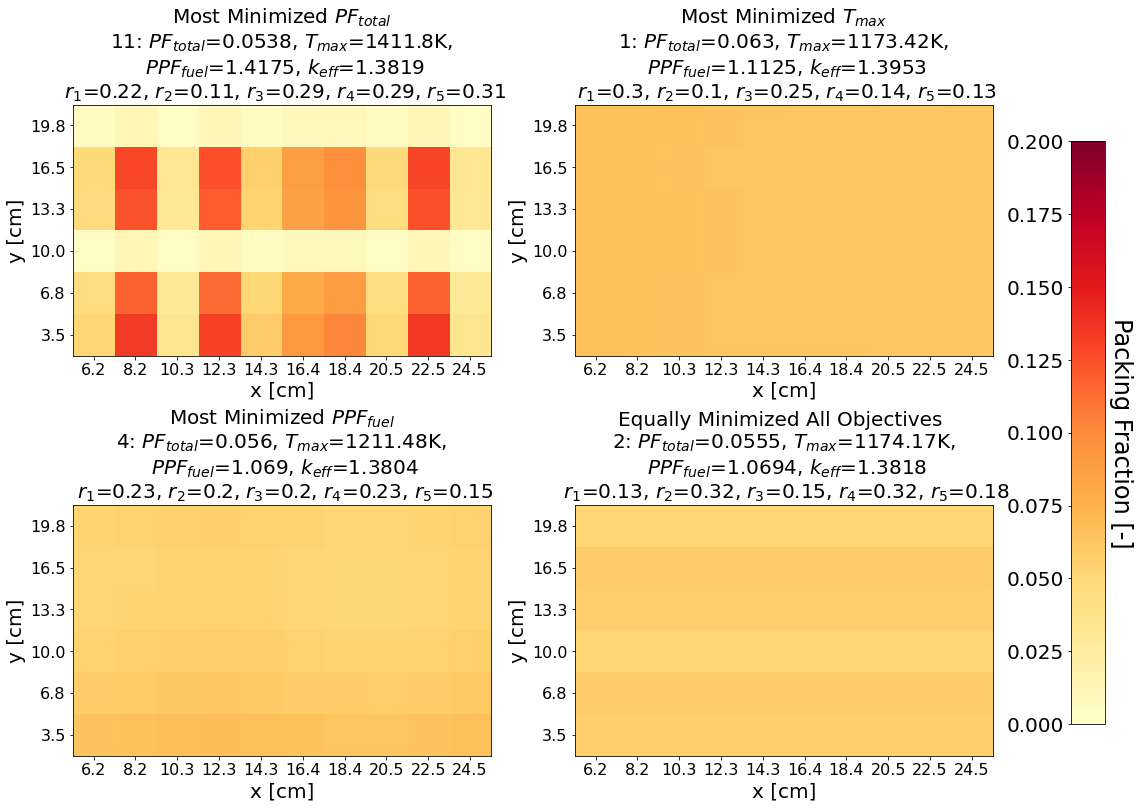

In [12]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
obj_0 = np.array([item.fitness.values[0] for item in non_dom])
obj_1 = np.array([item.fitness.values[1] for item in non_dom])
obj_2 = np.array([item.fitness.values[2] for item in non_dom])
pf_min = np.argsort(obj_0)[0]
temp_min = np.argsort(obj_1)[0]
ppf_min = np.argsort(obj_2)[0]
equally_min = 2-1
print("PF, TEMP, PPF", pf_min+1, temp_min+1, ppf_min+1)
fig, axes = plt.subplots(figsize=(12,13.5), nrows=2, ncols=2)
num = 1
count = 0
for i in [pf_min, temp_min, ppf_min, equally_min]:
    ind = non_dom[i]
    print("gen, num", ind.gen, ind.num)
    #print(ind)
    #print("PPF", obj_2[i])
    #print(i, ind)
    #print("fitness", ind.fitness)
    ax = axes.flat[count]
    count += 1
    pf_distr = calc_pf_distr(ind, True)
    print(i, "STD", np.std(pf_distr))
    for row in pf_distr:
        #print(np.max(row)- np.min(row))
        print(np.mean(row))
    #for j in range(10):
     #   col = pf_distr[:, j]
        #print(np.max(col)-np.min(col))
        #print(np.min(col))
    im = ax.imshow(pf_distr, vmin=0.00, vmax=0.2,cmap="YlOrRd")
    if i == pf_min:
        title_start = "Most Minimized $PF_{total}$ \n"
    elif i == temp_min:
        title_start = "Most Minimized $T_{max}$ \n"
    elif i == ppf_min:
        title_start = "Most Minimized $PPF_{fuel}$ \n"
    else:
        title_start = "Equally Minimized All Objectives \n"
    ax.set_title(title_start + str(i+1)+": $PF_{total}$="+str(round(ind.output[0],4)) + ", $T_{max}$="+str(round(ind.output[1],2))+
                 "K,\n $PPF_{fuel}$="+str(round(ind.output[2],4))+ ", $k_{eff}$="+str(round(ind.output[3],4))+
                 "\n $r_1$=" + str(round(ind[7],2)) + ", $r_2$=" + str(round(ind[8],2)) + ", $r_3$=" + str(round(ind[9],2)) +\
                     ", $r_4$=" + str(round(ind[10],2)) + ", $r_5$=" + str(round(ind[11],2)), fontsize=20)
    ax.set_xlabel("x [cm]", fontsize=20)
    ax.set_ylabel("y [cm]", fontsize=20)
    ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=16)
    ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=16)
    num += 1
fig.subplots_adjust(right=1.19)
cbar_ax = fig.add_axes([1.28, 0.2, 0.04, 0.6])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.ax.tick_params(labelsize=20)
cb.set_label("Packing Fraction [-]", fontsize=24, rotation=270, labelpad=28)
#ax.set_title("Final Generation's Pareto Front: TRISO Distribution", fontsize=24)
plt.savefig("assem-obj-3-all-distr-most-minimized.png",bbox_inches='tight', dpi=300)


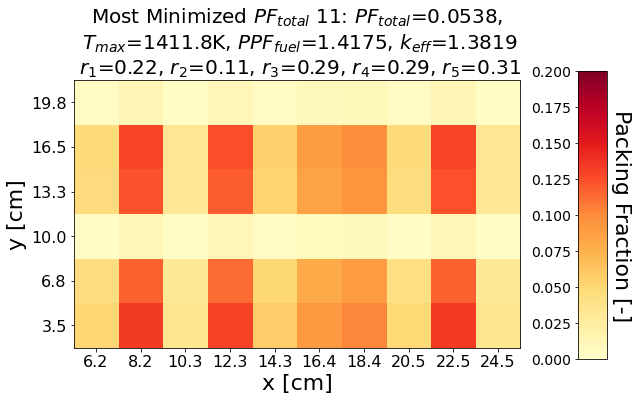

In [13]:
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
pf_most_minimized = final_non_dom[pf_min]
pf_distr = calc_pf_distr(pf_most_minimized, True)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
ax.set_title("Most Minimized $PF_{total}$ " + str(pf_min+1)+": $PF_{total}$="+str(round(pf_most_minimized.output[0],4)) +
             ",\n $T_{max}$="+str(round(pf_most_minimized.output[1],2))+
             "K, $PPF_{fuel}$="+str(round(pf_most_minimized.output[2],4))+
             ", $k_{eff}$="+str(round(pf_most_minimized.output[3],4))+
             "\n $r_1$=" + str(round(pf_most_minimized[7],2)) +
             ", $r_2$=" + str(round(pf_most_minimized[8],2)) +
             ", $r_3$=" + str(round(pf_most_minimized[9],2)) +
             ", $r_4$=" + str(round(pf_most_minimized[10],2)) +
             ", $r_5$=" + str(round(pf_most_minimized[11],2)), fontsize=20)
ax.set_xlabel("x [cm]", fontsize=22)
ax.set_ylabel("y [cm]", fontsize=22)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
ax.tick_params(axis='both', which='major', labelsize=16)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=24)
plt.savefig("a-3b-pf-most-minimized.png",bbox_inches='tight', dpi=300)


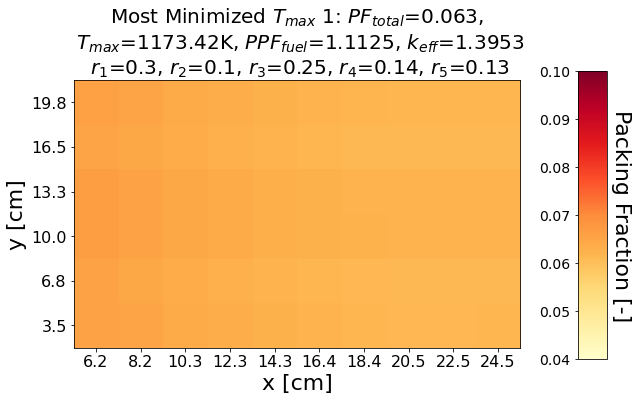

In [14]:
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
temp_most_minimized = final_non_dom[temp_min]
pf_distr = calc_pf_distr(temp_most_minimized, True)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0.04, vmax=0.1,cmap="YlOrRd")
ax.set_title("Most Minimized $T_{max}$ " + str(temp_min+1)+": $PF_{total}$="+str(round(temp_most_minimized.output[0],4)) +
             ",\n $T_{max}$="+str(round(temp_most_minimized.output[1],2))+
             "K, $PPF_{fuel}$="+str(round(temp_most_minimized.output[2],4))+
             ", $k_{eff}$="+str(round(temp_most_minimized.output[3],4))+
             "\n $r_1$=" + str(round(temp_most_minimized[7],2)) +
             ", $r_2$=" + str(round(temp_most_minimized[8],2)) +
             ", $r_3$=" + str(round(temp_most_minimized[9],2)) +
             ", $r_4$=" + str(round(temp_most_minimized[10],2)) +
             ", $r_5$=" + str(round(temp_most_minimized[11],2)), fontsize=20)
ax.set_xlabel("x [cm]", fontsize=22)
ax.set_ylabel("y [cm]", fontsize=22)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
ax.tick_params(axis='both', which='major', labelsize=16)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=24)
plt.savefig("a-3b-temp-most-minimized.png",bbox_inches='tight', dpi=300)


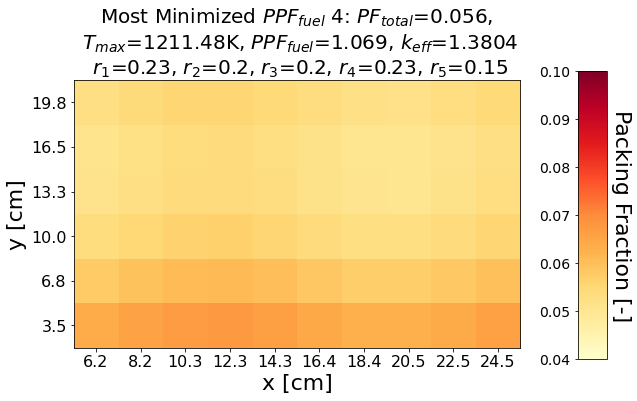

In [15]:
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
ppf_most_minimized = final_non_dom[ppf_min]
pf_distr = calc_pf_distr(ppf_most_minimized, True)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0.04, vmax=0.1,cmap="YlOrRd")
ax.set_title("Most Minimized $PPF_{fuel}$ " + str(ppf_min+1)+": $PF_{total}$="+str(round(ppf_most_minimized.output[0],4)) +
             ",\n $T_{max}$="+str(round(ppf_most_minimized.output[1],2))+
             "K, $PPF_{fuel}$="+str(round(ppf_most_minimized.output[2],4))+
             ", $k_{eff}$="+str(round(ppf_most_minimized.output[3],4))+
             "\n $r_1$=" + str(round(ppf_most_minimized[7],2)) +
             ", $r_2$=" + str(round(ppf_most_minimized[8],2)) +
             ", $r_3$=" + str(round(ppf_most_minimized[9],2)) +
             ", $r_4$=" + str(round(ppf_most_minimized[10],2)) +
             ", $r_5$=" + str(round(ppf_most_minimized[11],2)), fontsize=20)
ax.set_xlabel("x [cm]", fontsize=22)
ax.set_ylabel("y [cm]", fontsize=22)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
ax.tick_params(axis='both', which='major', labelsize=16)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=24)
plt.savefig("a-3b-ppf-most-minimized.png",bbox_inches='tight', dpi=300)


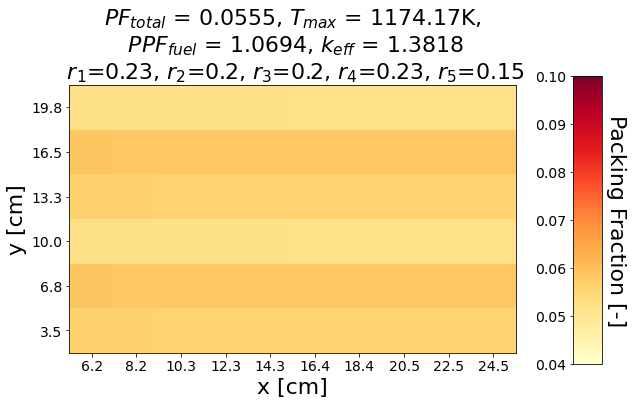

In [16]:
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]
all_most_minimized = final_non_dom[equally_min]
pf_distr = calc_pf_distr(all_most_minimized, True)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0.04, vmax=0.10,cmap="YlOrRd")
ax.set_title("$PF_{total}$ = "+str(round(all_most_minimized.output[0],4)) 
             + ", $T_{max}$ = "+str(round(all_most_minimized.output[1],2))
             + "K,\n $PPF_{fuel}$ = "+str(round(all_most_minimized.output[2],4))
             + ", $k_{eff}$ = "+str(round(all_most_minimized.output[3],4))
             + "\n $r_1$=" + str(round(ppf_most_minimized[7],2)) +
             ", $r_2$=" + str(round(ppf_most_minimized[8],2)) +
             ", $r_3$=" + str(round(ppf_most_minimized[9],2)) +
             ", $r_4$=" + str(round(ppf_most_minimized[10],2)) +
             ", $r_5$=" + str(round(ppf_most_minimized[11],2)), fontsize=22)
ax.set_xlabel("x [cm]", fontsize=22)
ax.set_ylabel("y [cm]", fontsize=22)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=14)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=14)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=24)
plt.savefig("a-3b-all-most-minimized.png",bbox_inches='tight', dpi=300)


In [17]:
def pf_radius_plot(num):
    results = cp["all"]
    fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=3)
    pop = results["populations"][-1]
    oups = results["outputs"][-1]
    for j in range(3):
        ax = axes.flat[j]
        obj = np.array([item[j] for item in oups])
        sorted_index_0 = np.argsort(obj)
        count, count2 = 0, 0
        for i, ind in enumerate(pop):
            oup = oups[i]
            if i in sorted_index_0[:5]:
                if count == 0:
                    ax.plot(ind[num], oup[j], 'rx', mew=3, label="5 reactor models with lowest $PF_{total}$")
                    count += 1
                else:
                    ax.plot(ind[num], oup[j], 'rx', mew=3)
            else:
                if count2 == 0 and count > 0:
                    ax.plot(ind[num], oup[j], 'k.', label="reactor models")
                    count2 += 1
                else:
                    ax.plot(ind[num], oup[j], 'k.')
    #ax.set_xlim([0.05, 0.35])
    #ax.set_ylim([0.01, 0.04])
        ax.set_xlabel("$r_"+str(num)+"$ [cm]", fontsize=20)
        ax.set_ylabel(str(j), fontsize=20)
        ax.grid()
    #ax.set_title("Final Generation: $PF_{total}$ vs Coolant Channel Shape's $r_"+str(num)+"$", fontsize=20)
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
    #plt.savefig("a-1d-r"+str(num)+".png",bbox_inches='tight')

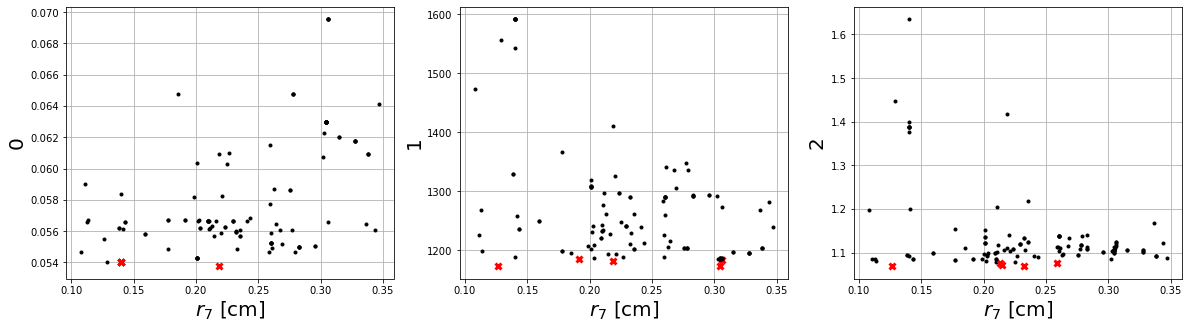

In [18]:
pf_radius_plot(7)

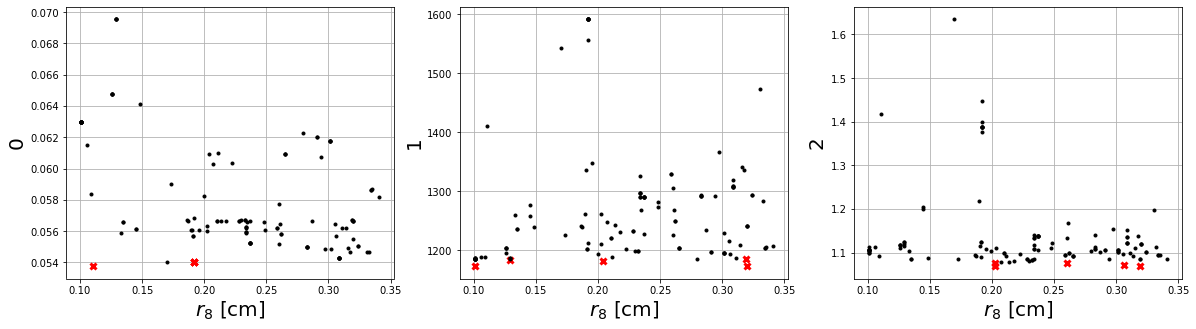

In [19]:
pf_radius_plot(8)

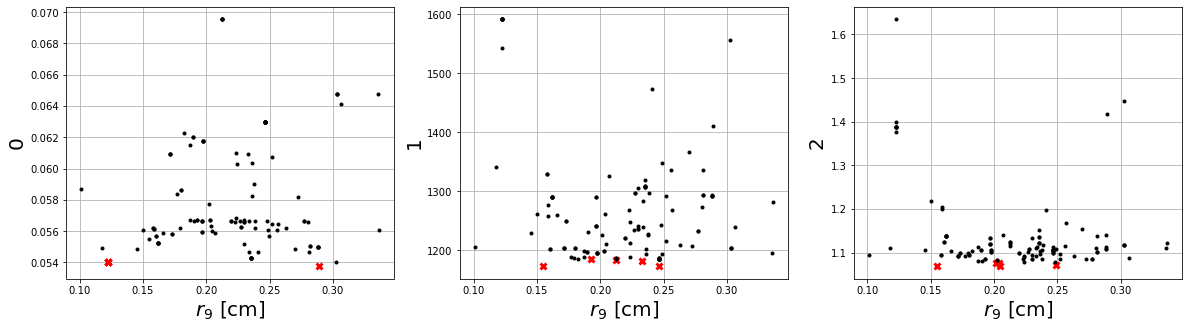

In [20]:
pf_radius_plot(9)

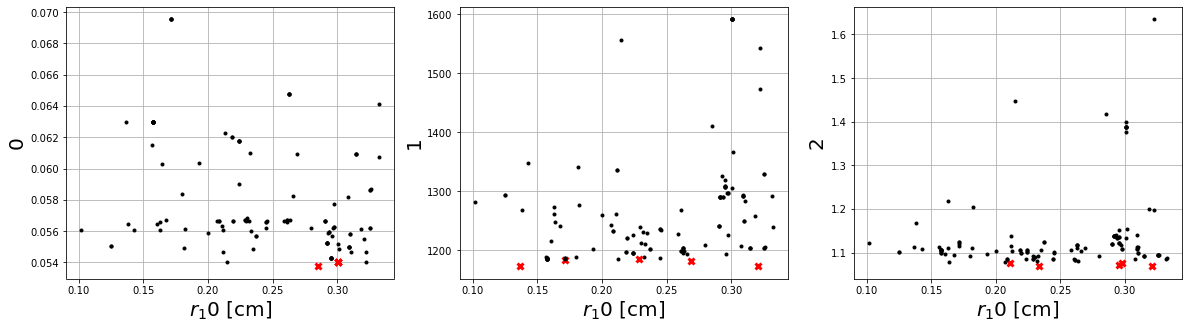

In [21]:
pf_radius_plot(10)

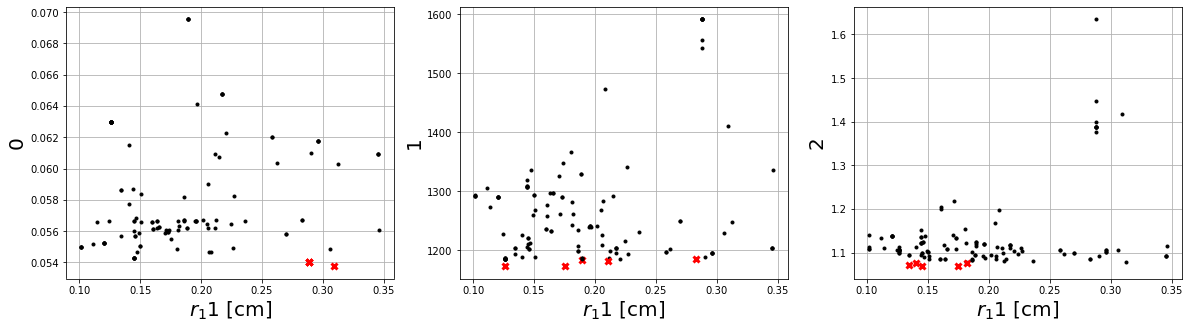

In [22]:
pf_radius_plot(11)

In [23]:
df_centerline_pf = pd.read_csv("./0_110/fhr_assem_moltres_csv_flux_centerline_0003.csv")
df_centerline_temp = pd.read_csv("./4_4/fhr_assem_moltres_csv_flux_centerline_0003.csv")
df_centerline_ppf = pd.read_csv("./5_16/fhr_assem_moltres_csv_flux_centerline_0003.csv")
df_centerline_all = pd.read_csv("./4_65/fhr_assem_moltres_csv_flux_centerline_0003.csv")

In [24]:
pf_most_minimized.fitness

deap.creator.obj((0.053756148172940214, 1411.8033679298, 1.4174909421859099))

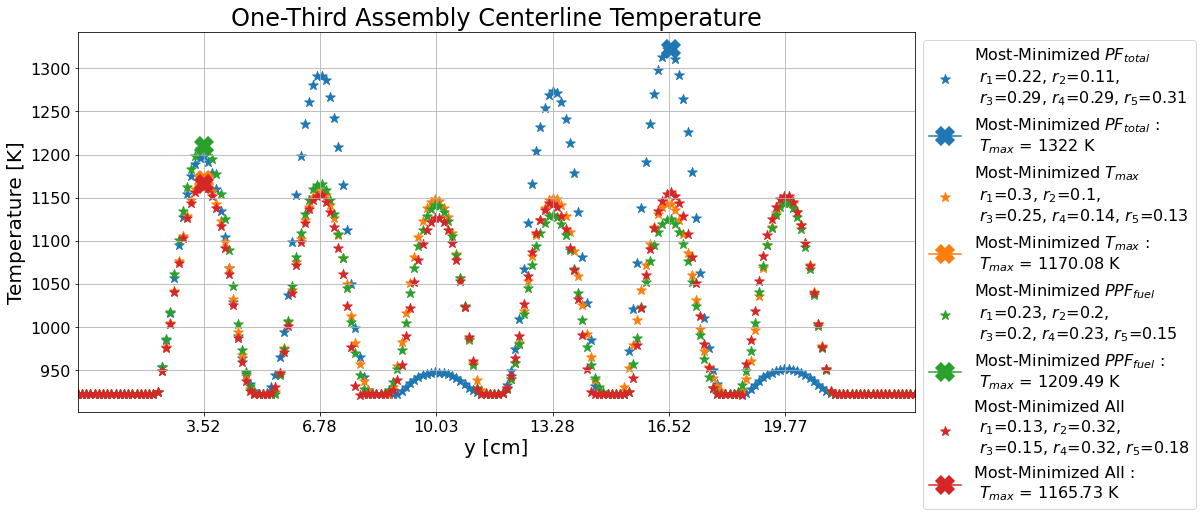

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(df_centerline_pf['y'], df_centerline_pf['temp'], marker='*', s=100, label="Most-Minimized $PF_{total}$"+
             "\n $r_1$=" + str(round(pf_most_minimized[7],2)) +
             ", $r_2$=" + str(round(pf_most_minimized[8],2)) +
             ",\n $r_3$=" + str(round(pf_most_minimized[9],2)) +
             ", $r_4$=" + str(round(pf_most_minimized[10],2)) +
             ", $r_5$=" + str(round(pf_most_minimized[11],2)))
pf_max_index = np.argmax(df_centerline_pf['temp'])
ax.plot(df_centerline_pf['y'][pf_max_index], df_centerline_pf['temp'][pf_max_index], marker="x", mew=20,
       label="Most-Minimized $PF_{total}$ :\n $T_{max}$ = "+str(round(df_centerline_pf['temp'][pf_max_index]))+" K")
ax.scatter(df_centerline_temp['y'], df_centerline_temp['temp'], marker='*', s=100, label="Most-Minimized $T_{max}$"+
             "\n $r_1$=" + str(round(temp_most_minimized[7],2)) +
             ", $r_2$=" + str(round(temp_most_minimized[8],2)) +
             ",\n $r_3$=" + str(round(temp_most_minimized[9],2)) +
             ", $r_4$=" + str(round(temp_most_minimized[10],2)) +
             ", $r_5$=" + str(round(temp_most_minimized[11],2)))
temp_max_index = np.argmax(df_centerline_temp['temp'])
ax.plot(df_centerline_temp['y'][temp_max_index], df_centerline_temp['temp'][temp_max_index], marker="x", mew=20,
        label="Most-Minimized $T_{max}$ :\n $T_{max}$ = "+str(round(df_centerline_temp['temp'][temp_max_index],2))+" K")
ax.scatter(df_centerline_ppf['y'], df_centerline_ppf['temp'], marker='*', s=100, label="Most-Minimized $PPF_{fuel}$"+
             "\n $r_1$=" + str(round(ppf_most_minimized[7],2)) +
             ", $r_2$=" + str(round(ppf_most_minimized[8],2)) +
             ",\n $r_3$=" + str(round(ppf_most_minimized[9],2)) +
             ", $r_4$=" + str(round(ppf_most_minimized[10],2)) +
             ", $r_5$=" + str(round(ppf_most_minimized[11],2)))
ppf_max_index = np.argmax(df_centerline_ppf['temp'])
ax.plot(df_centerline_ppf['y'][ppf_max_index], df_centerline_ppf['temp'][ppf_max_index], marker="x", mew=20,
       label="Most-Minimized $PPF_{fuel}$ :\n $T_{max}$ = "+str(round(df_centerline_ppf['temp'][ppf_max_index],2))+" K")
ax.scatter(df_centerline_all['y'], df_centerline_all['temp'], marker='*', s=100, label="Most-Minimized All"+
             "\n $r_1$=" + str(round(all_most_minimized[7],2)) +
             ", $r_2$=" + str(round(all_most_minimized[8],2)) +
             ",\n $r_3$=" + str(round(all_most_minimized[9],2)) +
             ", $r_4$=" + str(round(all_most_minimized[10],2)) +
             ", $r_5$=" + str(round(all_most_minimized[11],2)))
all_max_index = np.argmax(df_centerline_all['temp'])
ax.plot(df_centerline_all['y'][all_max_index], df_centerline_all['temp'][all_max_index], marker="x", mew=20,
       label="Most-Minimized All :\n $T_{max}$ = "+str(round(df_centerline_all['temp'][all_max_index],2))+" K")
ax.set_ylabel("Temperature [K]", fontsize=20)
ax.set_xlabel("y [cm]", fontsize=20)
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=16, bbox_to_anchor = [1.0, 1.0])
ax.set_title("One-Third Assembly Centerline Temperature", fontsize=24)
#ax.set_ylim([900, 1200])
ax.set_xticks([19.775, 16.525, 13.275, 10.025,  6.775,  3.525])
ax.set_xlim([0, 23.4])
plt.savefig("a-3b-centerline-temp.png",bbox_inches='tight', dpi=300)
# temperature peak corresponds to where radius value is high 